In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import IPython
import cv2
import glob

good_path_dir = '/home/tex/Datasets/mvtec_anomaly_detection/transistor/train/good/'
bad_path_dir = '/home/tex/Datasets/mvtec_anomaly_detection/transistor/test/**/'

def imshow(img):
    _,ret = cv2.imencode('.png', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

def fft(img: np.ndarray, kwargs: dict = {}) -> np.ndarray:
    """
    Compute the Fast Fourier Transform of an image.
    """
    # convert to grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform 2D FFT on the image
    fft_image = np.fft.fft2(img)
    
    # Shift the zero frequency component to the center of the spectrum
    shifted_fft = np.fft.fftshift(fft_image)
    
    # Compute the magnitude spectrum
    magn_spectrum = (20 * np.log(np.abs(shifted_fft))).astype(np.float32)
    
    _min_px = np.min(magn_spectrum)
    magn_spectrum = (magn_spectrum - _min_px) / (np.max(magn_spectrum) - _min_px) * 255.
    magn_spectrum = magn_spectrum.astype(np.uint8)
    
    return magn_spectrum

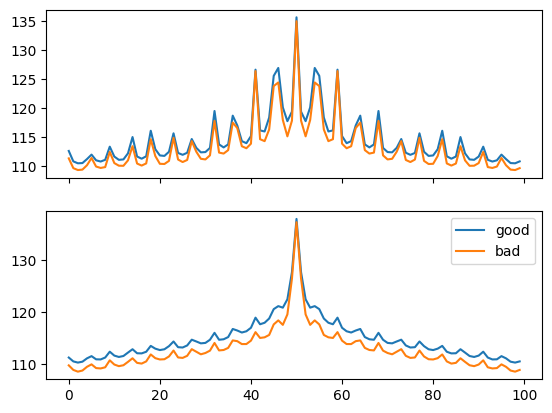

In [20]:
import time
window = 50
fig, axs = plt.subplots(2, sharex=True)
for im_path_dir in [good_path_dir, bad_path_dir]:
    freq_hist_list_x = []
    freq_hist_list_y = []
    for im_path in glob.glob(im_path_dir + '*.png', recursive=True):
        if "test/good" in im_path:
            continue
        # start = time.time()
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = fft(im)
        c = np.array([im.shape[0]//2, im.shape[1]//2])
        freq_hist_list_x.append(im.mean(axis=0)[c[1]-window:c[1]+window])
        freq_hist_list_y.append(im.mean(axis=1)[c[1]-window:c[1]+window])
        # print(f"{(time.time() - start) * 1000:.1f}", end="\r")
    freq_hist_list_x = np.array(freq_hist_list_x).mean(axis=0)
    freq_hist_list_y = np.array(freq_hist_list_y).mean(axis=0)
    axs[0].plot(freq_hist_list_x)
    axs[1].plot(freq_hist_list_y)
plt.legend(['good', 'bad'])
plt.show()

In [ ]:
import time

shape = (1024, 1024)
c = np.array([shape[0]//2, shape[1]//2])
masks = np.zeros((shape[0]//2, *shape), dtype=np.uint8)
masks_sum = np.zeros((shape[0]//2), dtype=np.int32)
masks[0][c[0], c[1]] = 1
masks_sum[0] = 1

for i in range(1, shape[0]//2):
    masks[i] = cv2.circle(masks[i], tuple(c), i, 1, 1)
    # argswhere.append(np.argwhere(masks[i] == 1))
    masks_sum[i] = masks[i].sum()

for im_path_dir in [good_path_dir, bad_path_dir]:
    freq_hist_list = []
    for im_path in glob.glob(im_path_dir + '*.png', recursive=True):
        if "test/good" in im_path:
            continue
        start = time.time()
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = fft(im)
        c = np.array([im.shape[0]//2, im.shape[1]//2])
        freq_hist = np.zeros((im.shape[0]//2), dtype=np.float32)
        freq_hist = (masks * im).sum(axis=(1, 2)) / masks_sum

        # for i in range(1, im.shape[0]//2):
        #     freq_hist.append(im[argswhere[i]].sum() / masks_sum[i])
        freq_hist_list.append(freq_hist)
        print(f"{(time.time() - start) * 1000:.1f}", end="\r")
    freq_hist_list = np.array(freq_hist_list).mean(axis=0)
    # linear interpolation to size 100 array
    # freq_hist = np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(freq_hist)), freq_hist)
    plt.plot(freq_hist_list)
plt.legend(['good', 'bad'])
plt.show()